In [9]:
#Reservoir simulation example. 1D, Oil phase only and homogeneous
library(ggplot2)
library(reshape2)

In [10]:
#Input Data
nx <- 5   #number of cells
beta <- 0.001127  #convertion factor
alpha <- 5.614  #convertion factor

dx <- 1000 #ft, dimension in x direction
dy <- 1000 #ft, dimension in y direction
dz <- 75 #ft, dimension in z direction

poro <- 0.18 #porosity, fraction
Cr <- 0 #rock Compressibility psi^-1
Cf <- 0.0000035 #fluid Compressibility  psi^-1
k <- 15 #permeability, md
Bo <- 1 #Formation volume factor, RB/STB
vis <- 10 #viscosity,cp 

#Well information
rw <- 3.5 #in, well radius
s <- 0 #skin
cellP <- 4 #well cell
qo <- -150 #well rate, STB/D

dt <- 15 #time step, days
TT <- 360 #total simulation time, days

Po <- 6000 #psi, Initial condition

In [11]:
#Previus calculations
Ax <- dy * dz #Faces area
vol <- dx * dy * dz #Cells volume
TE <- ((beta * Ax * k) / (vis * Bo * dx))  #  East transmisibility
TW <- ((beta * Ax * k) / (vis * Bo * dx))  #  West transmisibility

Acum <- ((vol * poro * (Cf + Cr)) / (alpha * Bo * dt))
time <- dt
Pt <- rep(Po, nx) #Pressure at time n
Ptdt <- rep(0, nx) #Pressure at time n + 1 

#geometry factor
req <- 0.14 * ((dx) **2 + (dy) ** 2) ** 0.5
FG <- (2 * 3.1416 * beta * k * dz) / (log(req / (rw / 12)) + s)

#Results data.frame
results_cells <- data.frame(0, t(Pt))
colnames(results_cells) <- c("Time", 1:nx)
cells_x <- seq(dx/2, (dx*nx)-(dx/2), length.out = nx)

results_pwf <- data.frame(Time = numeric(), Pwf = numeric())

In [12]:
#Thomas functions for tridiagonal matrix
thomas <- function(a,b,c,d,x,n){
  # Subroutine to solve a tridiagonal system
  # a = subdiagonal vector
  # B = diagonal vector
  # c = superdiagonal vector
  # d = right hand side vector
  # x = solution vector
  # n = number of diagonal vector elements 
  
  #Forward elimination
  for(i in 2:n){
    b[i] <- b[i]-a[i]*c[i-1]/b[i-1]
    d[i] <- d[i]-a[i]*d[i-1]/b[i-1]
  }
  
  #Back substitution
  x[n] <- d[n]/b[n]
  for(i in (nx-1):1){
    x[i] <- (d[i]-c[i]*x[i+1])/b[i]
  }
  
  return(x)
  
}

In [13]:
#Time loop
while( time <= TT ){
  
  aa <- rep(TW, nx)
  bb <- rep(-(TW + TE + Acum), nx)
  cc <- rep(TE, nx)
  dd <- rep(-Acum, nx)*Pt
  
  #Boundary condition, No flow
  #West
  bb[1] <- -(TE + Acum)
  #East
  bb[nx] <- -(TW + Acum)
  
  #Well
  dd[cellP] = dd[cellP] - qo
  
  Ptdt <- thomas(aa,bb,cc,dd,Ptdt,nx)
  
  Pt <- Ptdt
  
  pwf = qo / (FG / (Bo * vis)) + Pt[cellP]
  results_cells <- rbind(results_cells, c(time,Ptdt))
  results_pwf <-rbind(results_pwf, c(time, pwf))
  time = time + dt
}

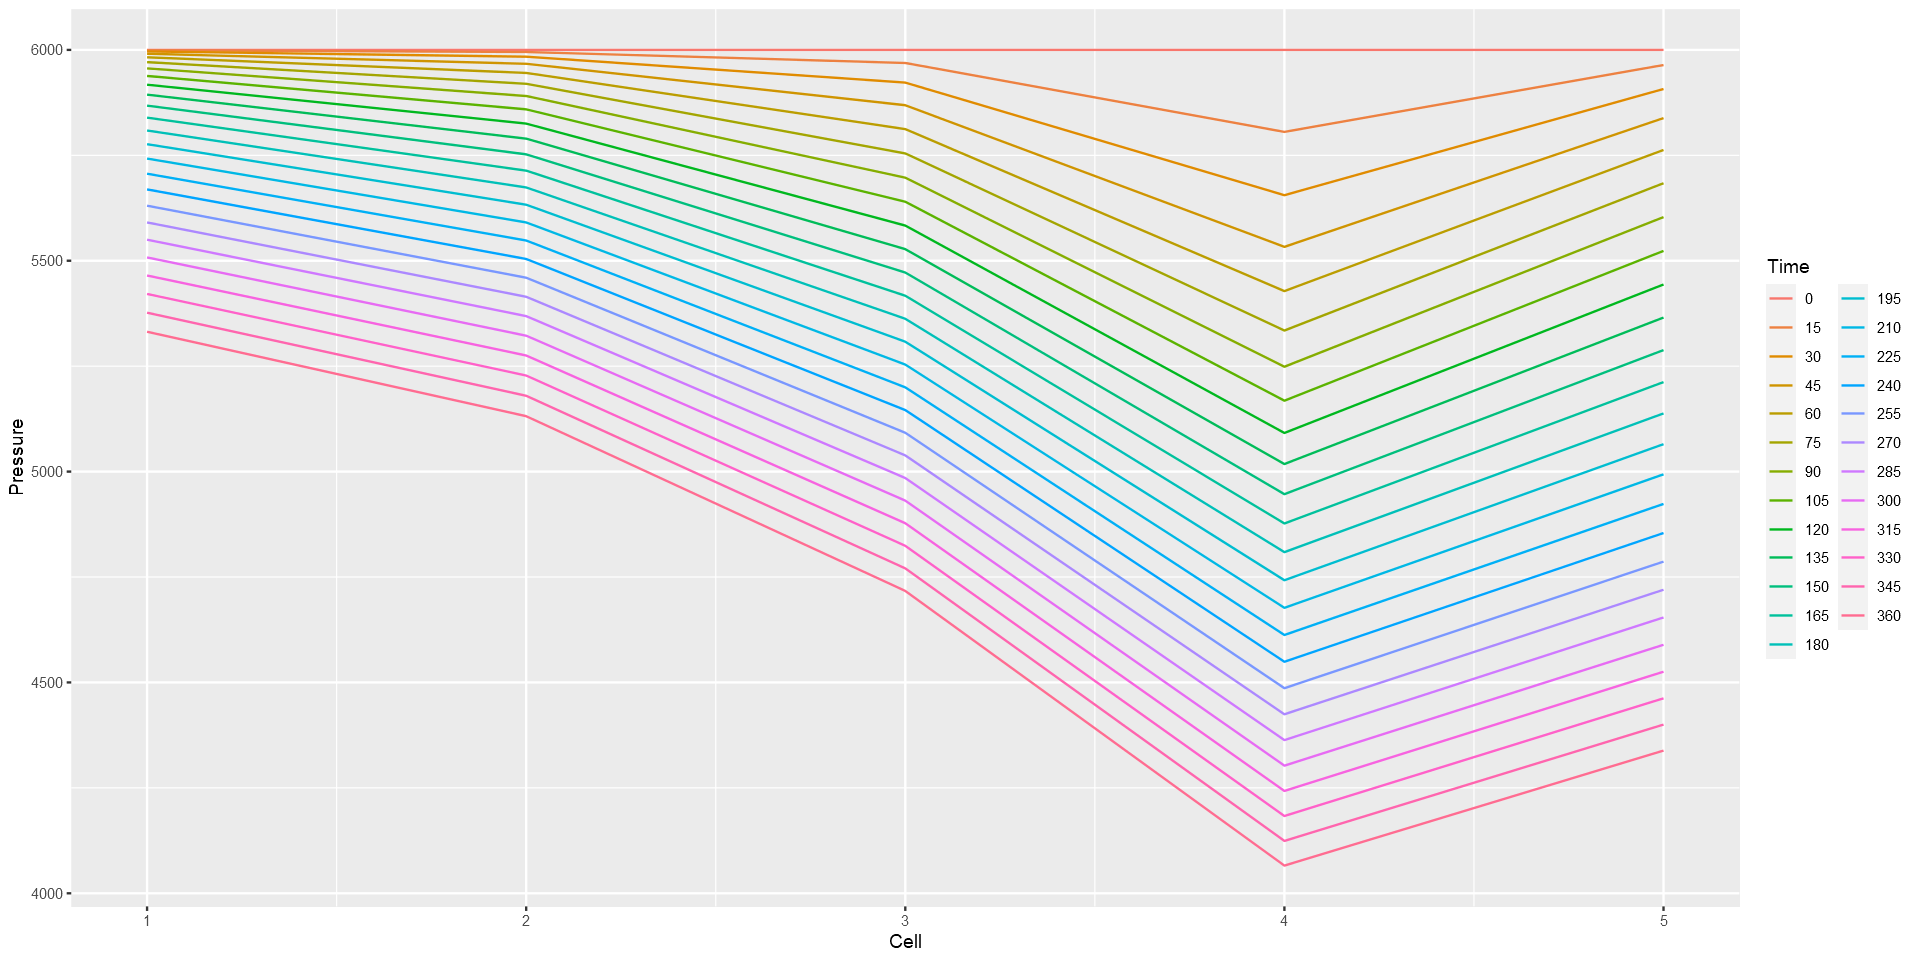

In [14]:
#Plot
options(repr.plot.width=16, repr.plot.height=8)
results_cells_time <-reshape2::melt(results_cells,id.vars=c("Time"))
colnames(results_cells_time) <- c("Time", "Cell", "Pressure")
results_cells_time$Time <- as.factor(results_cells_time$Time)
results_cells_time$Cell <- as.numeric(results_cells_time$Cell)
ggplot(results_cells_time, aes(Cell, Pressure, color = Time)) + 
      geom_line()

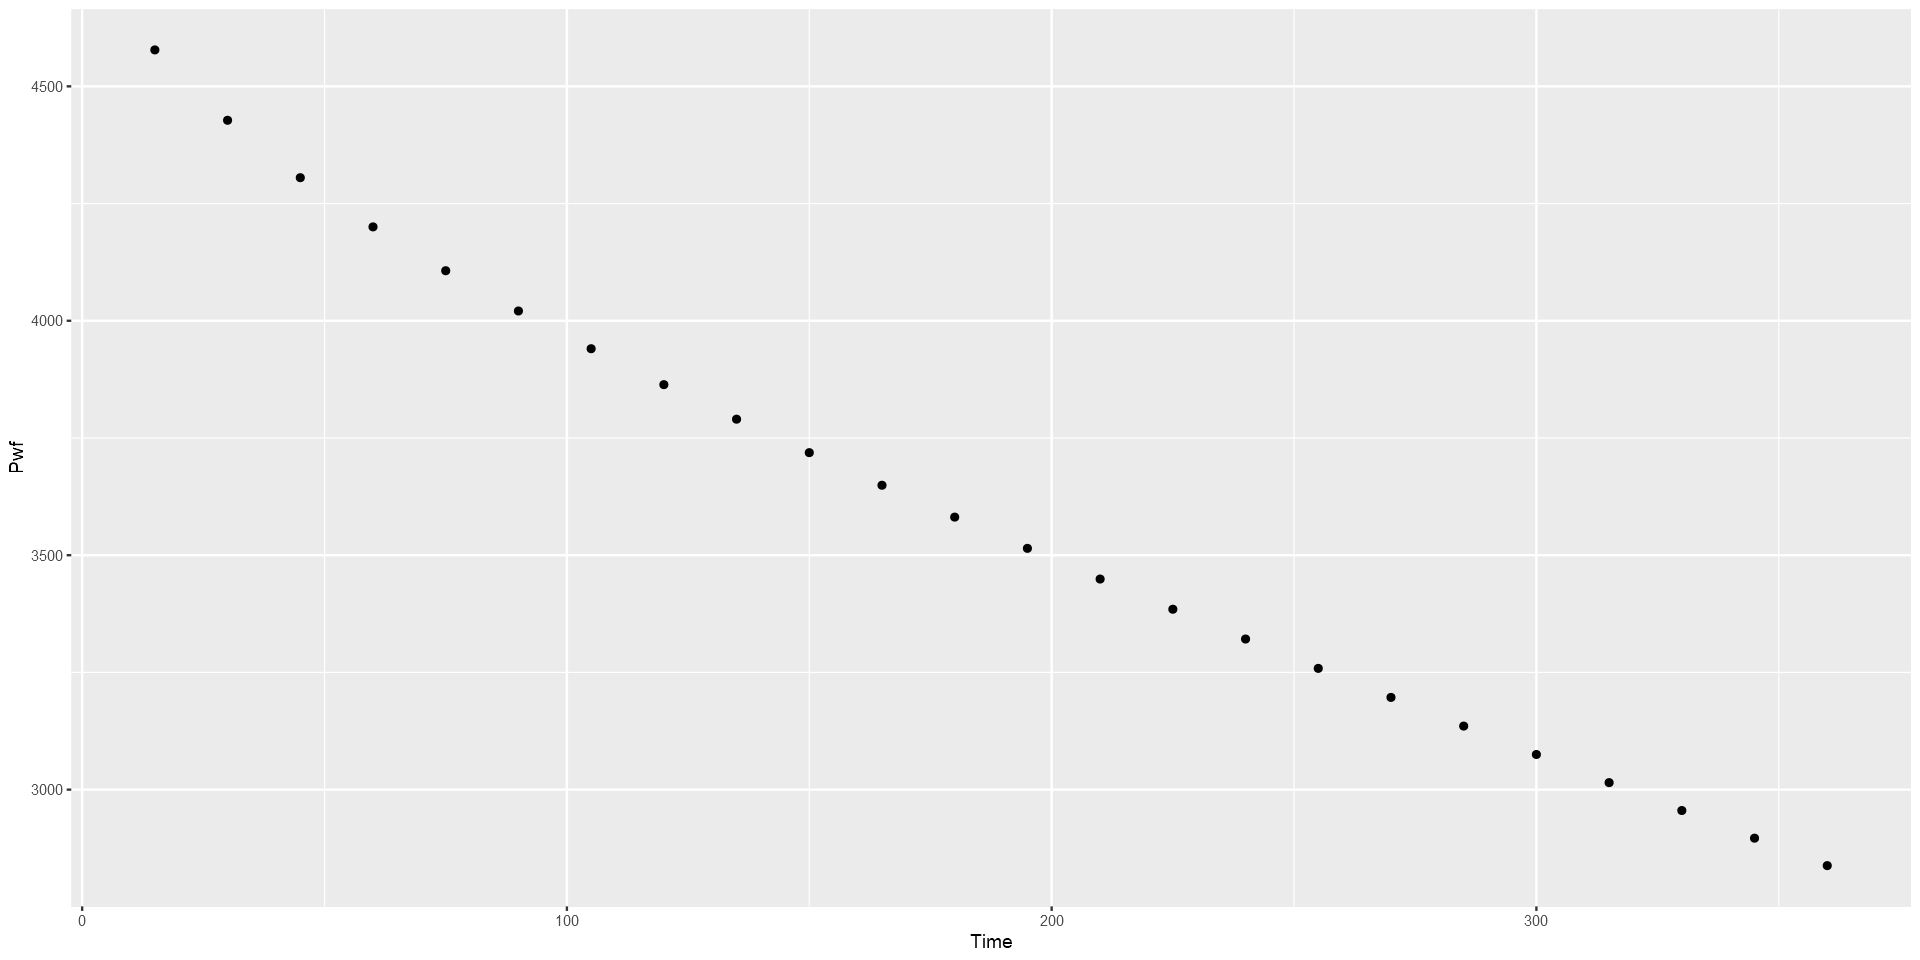

In [15]:
colnames(results_pwf) <-c("Time", "Pwf")
ggplot(results_pwf, aes(Time, Pwf)) + 
  geom_point()

In [16]:
print(results_cells)

   Time        1        2        3        4        5
1     0 6000.000 6000.000 6000.000 6000.000 6000.000
2    15 5999.083 5995.025 5968.950 5805.464 5964.144
3    30 5996.291 5983.932 5922.483 5655.392 5907.236
4    45 5990.910 5967.100 5868.802 5532.939 5838.248
5    60 5982.518 5945.380 5812.120 5428.013 5762.635
6    75 5970.932 5919.654 5754.523 5334.501 5683.724
7    90 5956.140 5890.678 5696.986 5248.661 5603.535
8   105 5938.245 5859.054 5639.909 5168.168 5523.291
9   120 5917.416 5825.238 5583.411 5091.553 5443.715
10  135 5893.854 5789.577 5527.480 5017.865 5365.224
11  150 5867.769 5752.329 5472.052 4946.474 5288.042
12  165 5839.371 5713.695 5417.043 4876.952 5212.272
13  180 5808.859 5673.830 5362.376 4808.993 5137.942
14  195 5776.419 5632.859 5307.981 4742.375 5065.033
15  210 5742.223 5590.886 5253.798 4676.927 4993.499
16  225 5706.424 5548.000 5199.782 4612.516 4923.278
17  240 5669.166 5504.277 5145.894 4549.031 4854.299
18  255 5630.574 5459.786 5092.105 4486.382 47